## THIS PYTHON CODE ALLOWS ANALYSIS OF ADAPTATIONS IN FLUORESCENCE WITHIN A BEHAVIORAL SESSION. E.G., SEE PANICCIA ET AL 2024 NEURON; FIGURE 1G

# IMPORT REQUIRED PACKAGES


In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import math
import os
import warnings
import scipy.stats as stats
import seaborn as sns


# FUNCTIONS FOR LOADING DATA FROM EXISTING DIRECTORIES

In [2]:
signals_filename_extension = 'raw_averaged'

def get_signals(indir):
    tempfiles = next(os.walk(indir))[2]
    npyfiles = [f for f in tempfiles if os.path.splitext(f)[1]=='.npy' and signals_filename_extension in f]
    if len(npyfiles) == 1:
        signals = np.squeeze(np.load(os.path.join(indir, npyfiles[0])))
    elif len(npyfiles) == 2:
        npyfile1 = [f for f in tempfiles if os.path.splitext(f)[1]=='.npy' \
                    and signals_filename_extension in f and 'part1' in f]
        npyfile2 = [f for f in tempfiles if os.path.splitext(f)[1]=='.npy' \
                    and signals_filename_extension in f and 'part2' in f]
        signals1 = np.squeeze(np.load(os.path.join(indir, npyfile1[0])))
        signals2 = np.squeeze(np.load(os.path.join(indir, npyfile2[0])))
        signals = np.hstack((signals1, signals2))
    elif len(npyfiles) == 3:
        npyfile1 = [f for f in tempfiles if os.path.splitext(f)[1]=='.npy' \
                    and signals_filename_extension in f and 'part1' in f]
        npyfile2 = [f for f in tempfiles if os.path.splitext(f)[1]=='.npy' \
                    and signals_filename_extension in f and 'part2' in f]
        npyfile3 = [f for f in tempfiles if os.path.splitext(f)[1]=='.npy' \
                    and signals_filename_extension in f and 'part3' in f]
        signals1 = np.squeeze(np.load(os.path.join(indir, npyfile1[0])))
        signals2 = np.squeeze(np.load(os.path.join(indir, npyfile2[0])))
        signals3 = np.squeeze(np.load(os.path.join(indir, npyfile3[0])))
        signals = np.hstack((signals1, signals2, signals3))
    else:
        warnings.warn('\nDATA FROM: \n%s \nNOT ANALYZED DUE TO NPY FILE DISCREPENCY\n'%indir)
    numneurons = np.shape(signals)[0]
    numframes = np.shape(signals)[1]
    
    return (numneurons, numframes, signals.astype(np.float64))
        


# DIRECTORY IDENTIFICATION

In [3]:
### INSERT YOUR DIRECTORY INFORMATION AND DAYS TO ANALYZE BELOW
### EACH DAY SHOULD BE A FOLDER WITHIN THE DIRECTORY 

#directory:
basedir = r'/Users/jmo204/Dropbox/2P Imaging Projects/Kelsey/PVT Self Admin'

#days (directory subfolders):
days = ['DrugExt', 'DrugRein','CueRein','YOHRein'] 


# LOAD DATA


In [4]:
### This section saves nested dictionaries for each day-->animal-->fov with 3 values in each dict:
### 1. an integer (numneurons), 2. an integer (numframes), and 3. a 2D (neuron x frame) numpy array (signals)

framerate = 7.5
maxframes = 0

signal_dict = {}
for day in days:
    print('Loaded Day: ', day)
    signal_dict[day] = {}
    animals = next(os.walk(os.path.join(basedir, day)))[1]
    for animal in animals:
        signal_dict[day][animal] = {}
        fovs = next(os.walk(os.path.join(basedir, day, animal)))[1]
        for fov in fovs:
            numneurons, numframes, raw_signals = get_signals(os.path.join(basedir, day, animal, fov))
            signal_dict[day][animal][fov] = numneurons, numframes, raw_signals
            if numframes > maxframes:
                maxframes = numframes
                

Loaded Day:  DrugExt
Loaded Day:  DrugRein
Loaded Day:  CueRein
Loaded Day:  YOHRein


# COMPARE DATA WITHIN SESSIONS

/var/folders/pk/ygvbglbn6bq1fx39y5xg76dc0000gn/T/ipykernel_10217/2418621249.py:23: RuntimeWarning: Mean of empty slice
  signalsbinned[:,j] = np.nanmean(signalsallneurons[:,j*framesperbin:(j+1)*framesperbin], axis = 1)


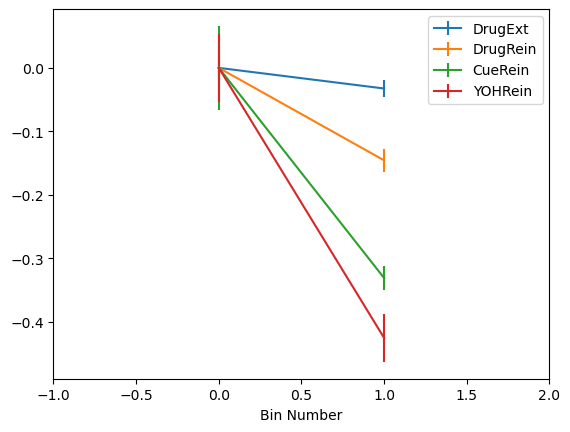

In [5]:
binsize = 3 ###in minutes
framesperbin = int(binsize*60*framerate)

for day in days:
    totalneurons = 0
    signalsallneurons = np.nan*np.ones((1, maxframes))
    animals = next(os.walk(os.path.join(basedir, day)))[1]
    for animal in animals:
        fovs = next(os.walk(os.path.join(basedir, day, animal)))[1]
        for fov in fovs:
            tempfiles = next(os.walk(os.path.join(basedir, day, animal, fov)))[2]
            numneurons = signal_dict[day][animal][fov][0]
            totalneurons+=numneurons
            for i in range(numneurons): ###looping through each neuron (numneurons)
                temp = np.nan*np.ones((maxframes))
                temp[0:len(signal_dict[day][animal][fov][2][i,:])] = \
                    signal_dict[day][animal][fov][2][i,:]
                signalsallneurons = np.vstack((signalsallneurons, temp))
    signalsallneurons = signalsallneurons[1:,:]
    numbins = int(np.ceil(signalsallneurons.shape[1]/framesperbin))
    signalsbinned = np.nan*np.ones((signalsallneurons.shape[0],numbins))
    for j in range(numbins):
        signalsbinned[:,j] = np.nanmean(signalsallneurons[:,j*framesperbin:(j+1)*framesperbin], axis = 1)
    
    baseline = np.mean(signalsbinned[:,0])
    signalsbinned = signalsbinned - baseline
    
###PLOTS FROM BEGINNING TO END FOR EACH NEURON

fig, ax = plt.subplots()

signalsbinned_dict={}

for day in days:
    signalsallneurons = np.nan*np.ones((1, 2))
    animals = next(os.walk(os.path.join(basedir, day)))[1]
    for animal in animals:
        fovs = next(os.walk(os.path.join(basedir, day, animal)))[1]
        for fov in fovs:
            numneurons = signal_dict[day][animal][fov][0]
            for i in range(numneurons): ###looping through each neuron (numneurons)
                temp = signal_dict[day][animal][fov][2][i,:]
                binstart = np.mean(temp[0:framesperbin])
                binend = np.mean(temp[-framesperbin-1:-1])
                temp = np.stack((binstart,binend))
                signalsallneurons = np.vstack((signalsallneurons, temp))

    signalsbinned = signalsallneurons[1:,:]  
    baseline = np.mean(signalsbinned[:,0])
    signalsbinned = signalsbinned - baseline
    signalsbinned_dict[day]=signalsbinned
    yerror = stats.sem(signalsbinned, nan_policy='omit')
    ax.errorbar(x = np.arange(signalsbinned.shape[1]), y = np.nanmean(signalsbinned, axis = 0),\
                 yerr = yerror)
    ax.set_xlabel('Bin Number')
#     ax.set_ylim(-0.05,0.01)
    ax.set_xlim(-1,2)


    ax.legend(days)


# STATISTICAL COMPARISONS USING ANOVA

In [6]:
####ANOVA OF ABOVE DATA
import pandas as pd
from statsmodels.stats.anova import AnovaRM
import statsmodels.api as sm
from statsmodels.formula.api import ols



###Create PANDAS Data Frame
df = {}
cellcounter = 0

for d, day in enumerate(days):
    numneurons = signalsbinned_dict[day].shape[0]

    df[d] = pd.DataFrame({'Neuron': cellcounter + np.tile(np.arange(numneurons),2),
                    'Time': np.append(np.repeat(['Pre'], numneurons),np.repeat(['Post'], numneurons)),
                    'Day': np.repeat([day], numneurons*2),
                    'Adaptation': np.concatenate((signalsbinned_dict[day][:,0], \
                                                 signalsbinned_dict[day][:,1]))})   
    if d ==0:
        df_stacked = df[d]
    if d != 0:
        df_stacked = pd.concat([df_stacked,df[d]], axis=0)

    cellcounter += numneurons        

df_stacked

###Perform two-way ANOVA
model = ols('Adaptation  ~ C(Time) + C(Day) + C(Time):C(Day)', data=df_stacked).fit()
anova = sm.stats.anova_lm(model, typ=2)
sm.stats.anova_lm(model, typ=2)

,sum_sq,df,F,PR(>F)
C(Time),10.199865,1.0,84.752680,2.655738e-19
C(Day),4.637292,3.0,12.844057,3.282744e-08
C(Time):C(Day),4.637292,3.0,12.844057,3.282744e-08
Residual,100.611413,836.0,NaN,NaN
